[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Mar 24 23:44:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 96.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-02-19 17:12:39--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-02-19 17:12:39 (95.4 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

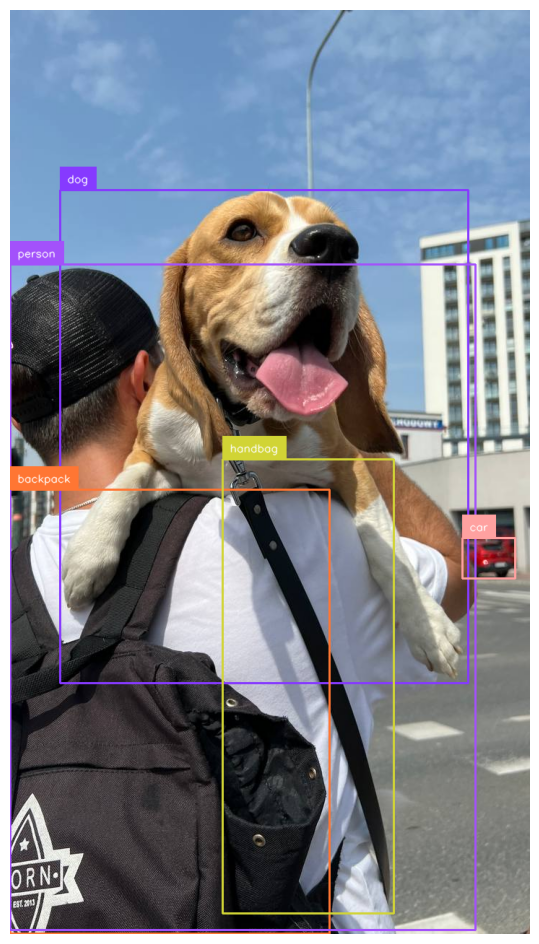

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [5]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/roboflow-100/hand-gestures-jps7z/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hand-gestures-2 in yolov8:: 100%|██████████| 1840/1840 [00:00<00:00, 8333.44it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [7]:
!cat {dataset.location}/data.yaml

names:
- '0'
- '1'
- '10'
- '11'
- '12'
- '13'
- '2'
- '3'
- '4'
- '5'
- '6'
- '7'
- '8'
- '9'
nc: 14
roboflow:
  license: CC BY 4.0
  project: hand-gestures-jps7z
  url: https://universe.roboflow.com/roboflow-100/hand-gestures-jps7z/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [8]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.96 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/hand-gestures-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]


Overriding model.yaml nc=80 with nc=14

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 313MB/s]


AMP: checks passed ✅


train: Scanning /content/hand-gestures-2/train/labels... 642 images, 0 backgrounds, 0 corrupt: 100%|██████████| 642/642 [00:00<00:00, 2353.98it/s]

train: New cache created: /content/hand-gestures-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/hand-gestures-2/valid/labels... 178 images, 0 backgrounds, 0 corrupt: 100%|██████████| 178/178 [00:00<00:00, 1821.32it/s]


val: New cache created: /content/hand-gestures-2/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000556, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.85G      3.528      6.053      4.307          7        640: 100%|██████████| 41/41 [00:24<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]

                   all        178        178          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.92G      3.276      5.749      4.052          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all        178        178          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.92G      3.086      5.364      3.715          4        640: 100%|██████████| 41/41 [00:20<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all        178        178          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       6.9G      2.775      4.813      3.316          6        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]

                   all        178        178    0.00507      0.695     0.0849     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.94G      2.505      4.174      2.982          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        178        178      0.938     0.0698     0.0706     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.95G      2.357      3.673      2.766          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.06it/s]

                   all        178        178      0.893     0.0544     0.0734      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.95G      2.227      3.388      2.654          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


                   all        178        178      0.554      0.321      0.378      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       6.9G      2.192       3.16      2.627          2        640: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


                   all        178        178      0.476      0.334      0.335      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.93G      2.092      2.944      2.516          2        640: 100%|██████████| 41/41 [00:22<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


                   all        178        178       0.64      0.414      0.499      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.95G      2.061        2.7      2.472          5        640: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


                   all        178        178      0.612      0.481      0.544       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.95G      2.018      2.589      2.361          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


                   all        178        178      0.502      0.576      0.581      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       6.9G        1.9      2.359      2.286          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


                   all        178        178      0.635       0.65      0.717      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.93G      1.881      2.294       2.25          2        640: 100%|██████████| 41/41 [00:23<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


                   all        178        178      0.735      0.611      0.808      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.94G      1.836       2.16      2.198          7        640: 100%|██████████| 41/41 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


                   all        178        178       0.73      0.743      0.806      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.95G      1.776      2.042      2.192          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

                   all        178        178      0.847      0.724      0.861       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       6.9G      1.777      1.982      2.167          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


                   all        178        178      0.701       0.75      0.856      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.93G      1.729      1.911      2.124          6        640: 100%|██████████| 41/41 [00:22<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]


                   all        178        178      0.815      0.731      0.841      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.94G      1.664       1.81      2.062          2        640: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


                   all        178        178      0.688      0.814      0.839      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.95G      1.628       1.77      2.051          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


                   all        178        178      0.669      0.779      0.862      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.9G      1.629      1.744      2.019          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


                   all        178        178      0.853      0.783      0.919       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.93G      1.601      1.681      1.978          6        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


                   all        178        178      0.802      0.894       0.93      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.94G      1.586      1.629      1.988          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


                   all        178        178       0.82      0.866       0.92      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.95G       1.56      1.645      1.968          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


                   all        178        178      0.871      0.829      0.933      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       6.9G      1.551      1.575      1.942          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]


                   all        178        178      0.893      0.875      0.944       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.93G      1.501      1.534      1.879          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


                   all        178        178      0.833      0.857      0.934      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.95G      1.431      1.406      1.826          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

                   all        178        178      0.932      0.901      0.967      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.95G      1.422      1.433      1.838          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

                   all        178        178      0.887       0.91      0.957      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       6.9G      1.404      1.368      1.795          6        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        178        178      0.909      0.904      0.959      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.93G      1.417       1.37      1.823          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all        178        178      0.916       0.88      0.958      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.95G      1.444      1.386      1.829          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


                   all        178        178      0.869       0.87      0.949      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.95G      1.427      1.359      1.794          7        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        178        178      0.905       0.92       0.97      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       6.9G      1.427      1.364      1.825          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


                   all        178        178      0.907      0.902      0.973      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.93G      1.386      1.325      1.794          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        178        178      0.915      0.891      0.972      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.94G      1.378        1.3      1.779          6        640: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        178        178      0.906      0.922      0.967      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.95G      1.365      1.285      1.736          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        178        178      0.939      0.948      0.975      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       6.9G      1.339      1.263      1.754          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


                   all        178        178      0.885      0.919      0.967       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.93G      1.297      1.257      1.711          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]


                   all        178        178      0.934      0.919      0.977      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.95G      1.324      1.204      1.718          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

                   all        178        178      0.941      0.949      0.986      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.95G      1.296      1.177       1.69          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        178        178      0.944      0.926      0.981      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       6.9G      1.284      1.172      1.713          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        178        178      0.942      0.946      0.984      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.93G      1.276      1.151      1.674          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all        178        178      0.915      0.961      0.987      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.95G      1.255       1.15      1.681          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


                   all        178        178      0.903      0.959      0.976      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.95G      1.298      1.148      1.689          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


                   all        178        178       0.95      0.928      0.979      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       6.9G      1.247      1.099      1.639          2        640: 100%|██████████| 41/41 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all        178        178      0.913      0.911      0.977      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.93G      1.239      1.085      1.634          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


                   all        178        178      0.895      0.952      0.981      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.94G       1.26      1.099       1.65          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


                   all        178        178      0.936      0.932      0.979      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.95G      1.202      1.061      1.592          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


                   all        178        178      0.922      0.939      0.976      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.9G      1.228      1.062      1.634          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all        178        178      0.928      0.981      0.985      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.93G      1.184      1.023      1.578          8        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


                   all        178        178      0.956       0.95      0.991       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.95G      1.192       1.01      1.566          7        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


                   all        178        178      0.951      0.956      0.985      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.95G        1.2      1.032       1.59          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        178        178      0.951      0.971       0.99      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       6.9G      1.161      1.027      1.568          7        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        178        178      0.945       0.98      0.992      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.93G      1.158     0.9987      1.587          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all        178        178      0.941      0.969      0.985      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.95G      1.182      1.005      1.582          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


                   all        178        178      0.966      0.943      0.982       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.95G      1.189       0.98      1.577          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all        178        178      0.929      0.979      0.989      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       6.9G      1.186     0.9935      1.561          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all        178        178      0.928      0.975      0.983      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.93G      1.198     0.9869      1.585          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        178        178      0.939      0.976      0.988       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.94G      1.134     0.9577      1.539          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


                   all        178        178      0.957      0.979      0.992      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.95G       1.13     0.9642      1.524          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


                   all        178        178      0.967      0.956      0.992      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.9G      1.182     0.9693      1.578          6        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


                   all        178        178      0.961      0.989      0.993      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.93G      1.201     0.9917       1.58          7        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


                   all        178        178      0.965      0.979      0.991      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.94G      1.123     0.9413      1.524          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        178        178       0.96      0.986      0.989      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.95G      1.137      0.905      1.544          8        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

                   all        178        178       0.95      0.969      0.989      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       6.9G      1.074     0.9436      1.489          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        178        178      0.937      0.984      0.988       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.93G      1.128     0.9114      1.537          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

                   all        178        178      0.957      0.982      0.991      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.94G      1.144     0.9427      1.537          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        178        178      0.956      0.969      0.988       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.95G      1.092     0.9175      1.484          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        178        178      0.966      0.983      0.989      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       6.9G      1.085     0.8687      1.508          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


                   all        178        178      0.981       0.98      0.994      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.93G       1.12     0.8812      1.512          8        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


                   all        178        178       0.95      0.942      0.984      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.94G      1.067     0.8922        1.5          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


                   all        178        178      0.956      0.975      0.985      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.95G      1.085     0.8988      1.504          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


                   all        178        178      0.935       0.97      0.983      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       6.9G       1.07      0.851      1.475          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        178        178      0.949      0.984      0.992      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.93G       1.07     0.8746      1.491          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


                   all        178        178       0.97       0.98      0.992      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.94G      1.132     0.9092      1.527          4        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


                   all        178        178      0.966      0.984      0.992      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.95G      1.063     0.8639      1.453          4        640: 100%|██████████| 41/41 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


                   all        178        178       0.95      0.985       0.99      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.9G      1.102     0.8791      1.486          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


                   all        178        178      0.968      0.977      0.991      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.93G      1.061     0.8574       1.46          5        640: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        178        178      0.955       0.99       0.99      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.95G      1.077     0.8939        1.5          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        178        178      0.965      0.979       0.99      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.95G      1.059     0.8767      1.463          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all        178        178      0.957      0.988      0.989      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.9G      1.025     0.8421      1.435          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        178        178      0.956      0.977      0.986      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.93G      1.011     0.8062      1.419          4        640: 100%|██████████| 41/41 [00:24<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


                   all        178        178      0.967      0.979       0.99      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.94G      1.041     0.8342      1.456          6        640: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        178        178       0.96      0.988      0.989      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.93G     0.9984     0.8148      1.417          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


                   all        178        178      0.958      0.985       0.99       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       6.9G      1.029     0.8142      1.425          4        640: 100%|██████████| 41/41 [00:22<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


                   all        178        178      0.954       0.99      0.989      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.93G      1.002     0.8272       1.41          3        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


                   all        178        178      0.959      0.978      0.991      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.95G      1.002     0.8031      1.427          1        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


                   all        178        178       0.96      0.985       0.99      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.95G          1     0.7957      1.421          4        640: 100%|██████████| 41/41 [00:23<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]

                   all        178        178      0.972      0.991      0.989      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       6.9G      1.015     0.8141      1.428          3        640: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]


                   all        178        178      0.969      0.982      0.991      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.93G      1.007     0.8136      1.436          5        640: 100%|██████████| 41/41 [00:22<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]


                   all        178        178      0.972      0.984      0.992      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.95G     0.9992     0.7925      1.421          6        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


                   all        178        178      0.973       0.99      0.992      0.719
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.93G     0.9026     0.6997      1.417          2        640: 100%|██████████| 41/41 [00:23<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


                   all        178        178      0.963      0.961      0.994      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.89G     0.8959     0.6599      1.412          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


                   all        178        178      0.957      0.988      0.992      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.93G     0.8555     0.6206      1.386          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


                   all        178        178      0.976      0.987      0.993      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.93G     0.8466     0.6247      1.394          2        640: 100%|██████████| 41/41 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        178        178      0.967      0.989      0.992      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.93G     0.8457     0.6132       1.37          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


                   all        178        178      0.971      0.985      0.993       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.89G     0.8637     0.6148      1.397          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        178        178      0.969      0.987      0.993      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.93G     0.8405     0.6139      1.384          2        640: 100%|██████████| 41/41 [00:22<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


                   all        178        178      0.963      0.985      0.994       0.72

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.93G     0.8207      0.597      1.361          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


                   all        178        178      0.963       0.99      0.994      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.93G     0.8073      0.593      1.334          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

                   all        178        178      0.972      0.986      0.993      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.89G     0.8129     0.6018       1.36          2        640: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        178        178      0.972      0.986      0.993      0.725



100 epochs completed in 0.701 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,079,626 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


                   all        178        178      0.964      0.988      0.994      0.728
                     0          4          4      0.914          1      0.995      0.567
                     1         13         13      0.965          1      0.995      0.736
                    10          8          8      0.973          1      0.995       0.74
                    11         14         14       0.87      0.953      0.976      0.627
                    12          9          9      0.971          1      0.995      0.657
                    13         33         33      0.996          1      0.995      0.782
                     2         11         11          1      0.922      0.995      0.642
                     3         10         10      0.996          1      0.995       0.81
                     4         10         10      0.981          1      0.995      0.624
                     5         12         12      0.969          1      0.995      0.732
                     

## Evaluate fine-tuned YOLOv12 model

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv		val_batch0_pred.jpg
confusion_matrix.png				   results.png		val_batch1_labels.jpg
events.out.tfevents.1742860547.03fb2cef4a7a.894.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					   train_batch1.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch2.jpg	val_batch2_pred.jpg
labels.jpg					   train_batch3690.jpg	weights
P_curve.png					   train_batch3691.jpg
PR_curve.png					   train_batch3692.jpg


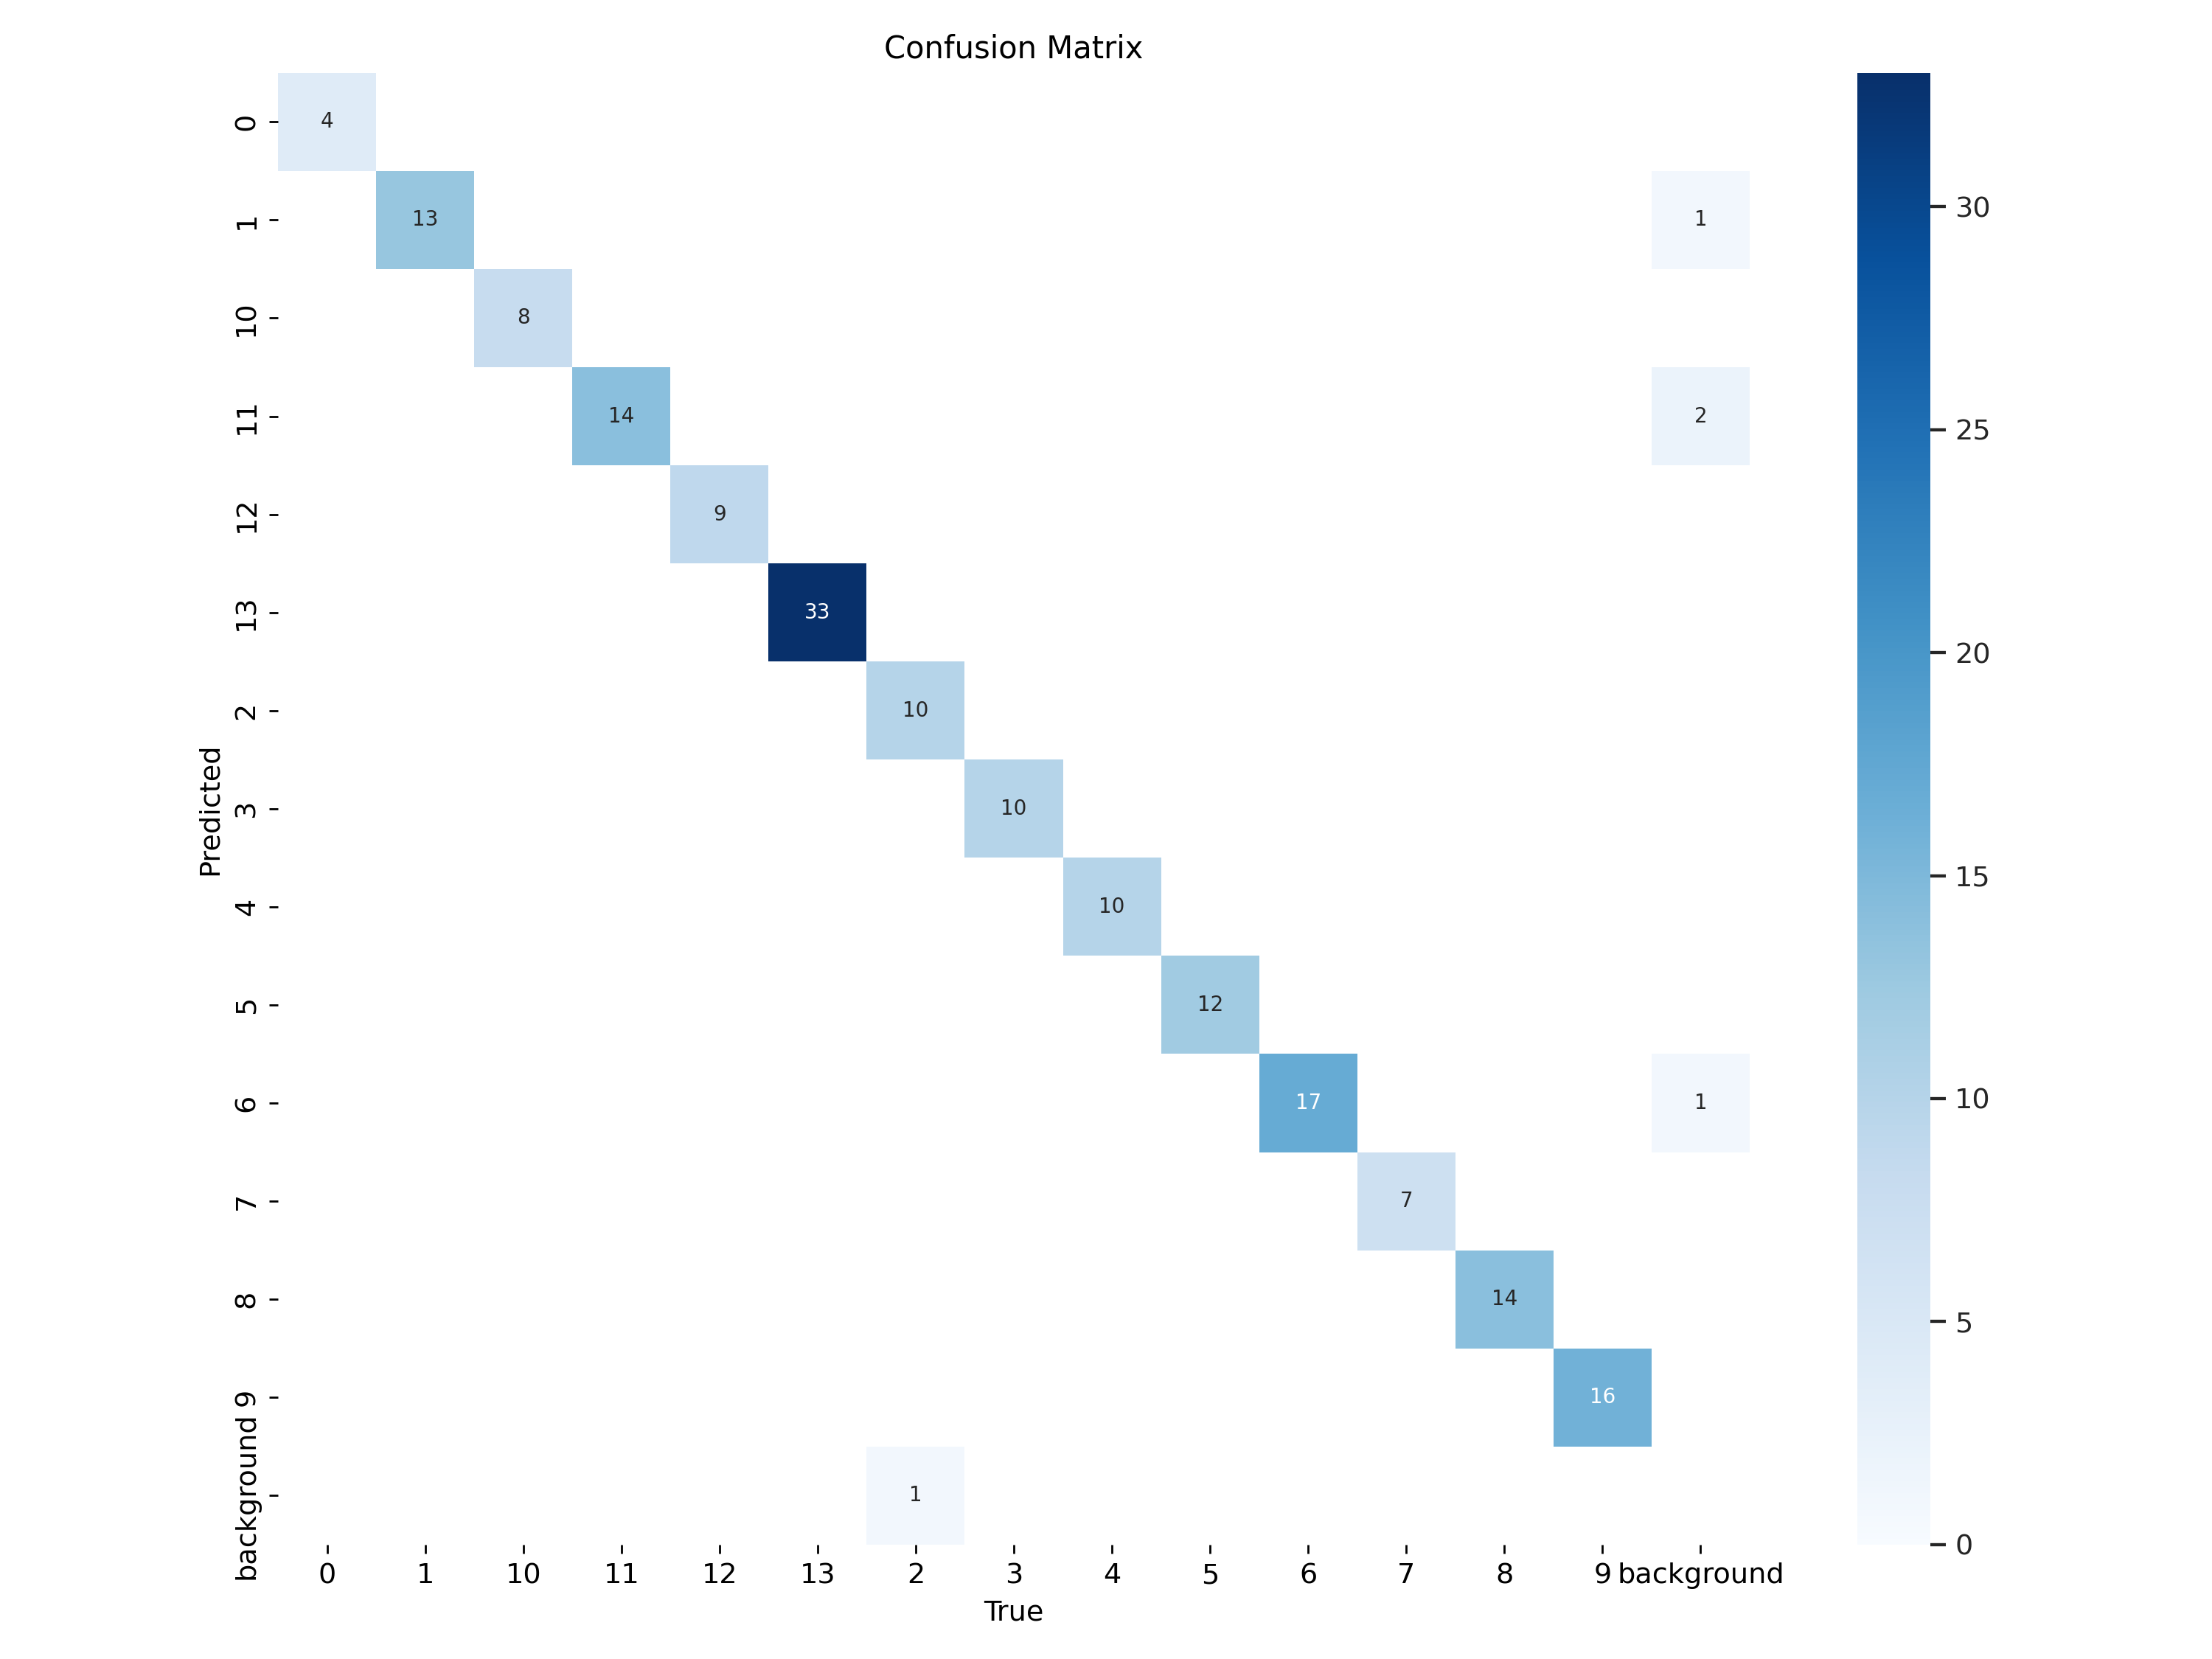

In [10]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

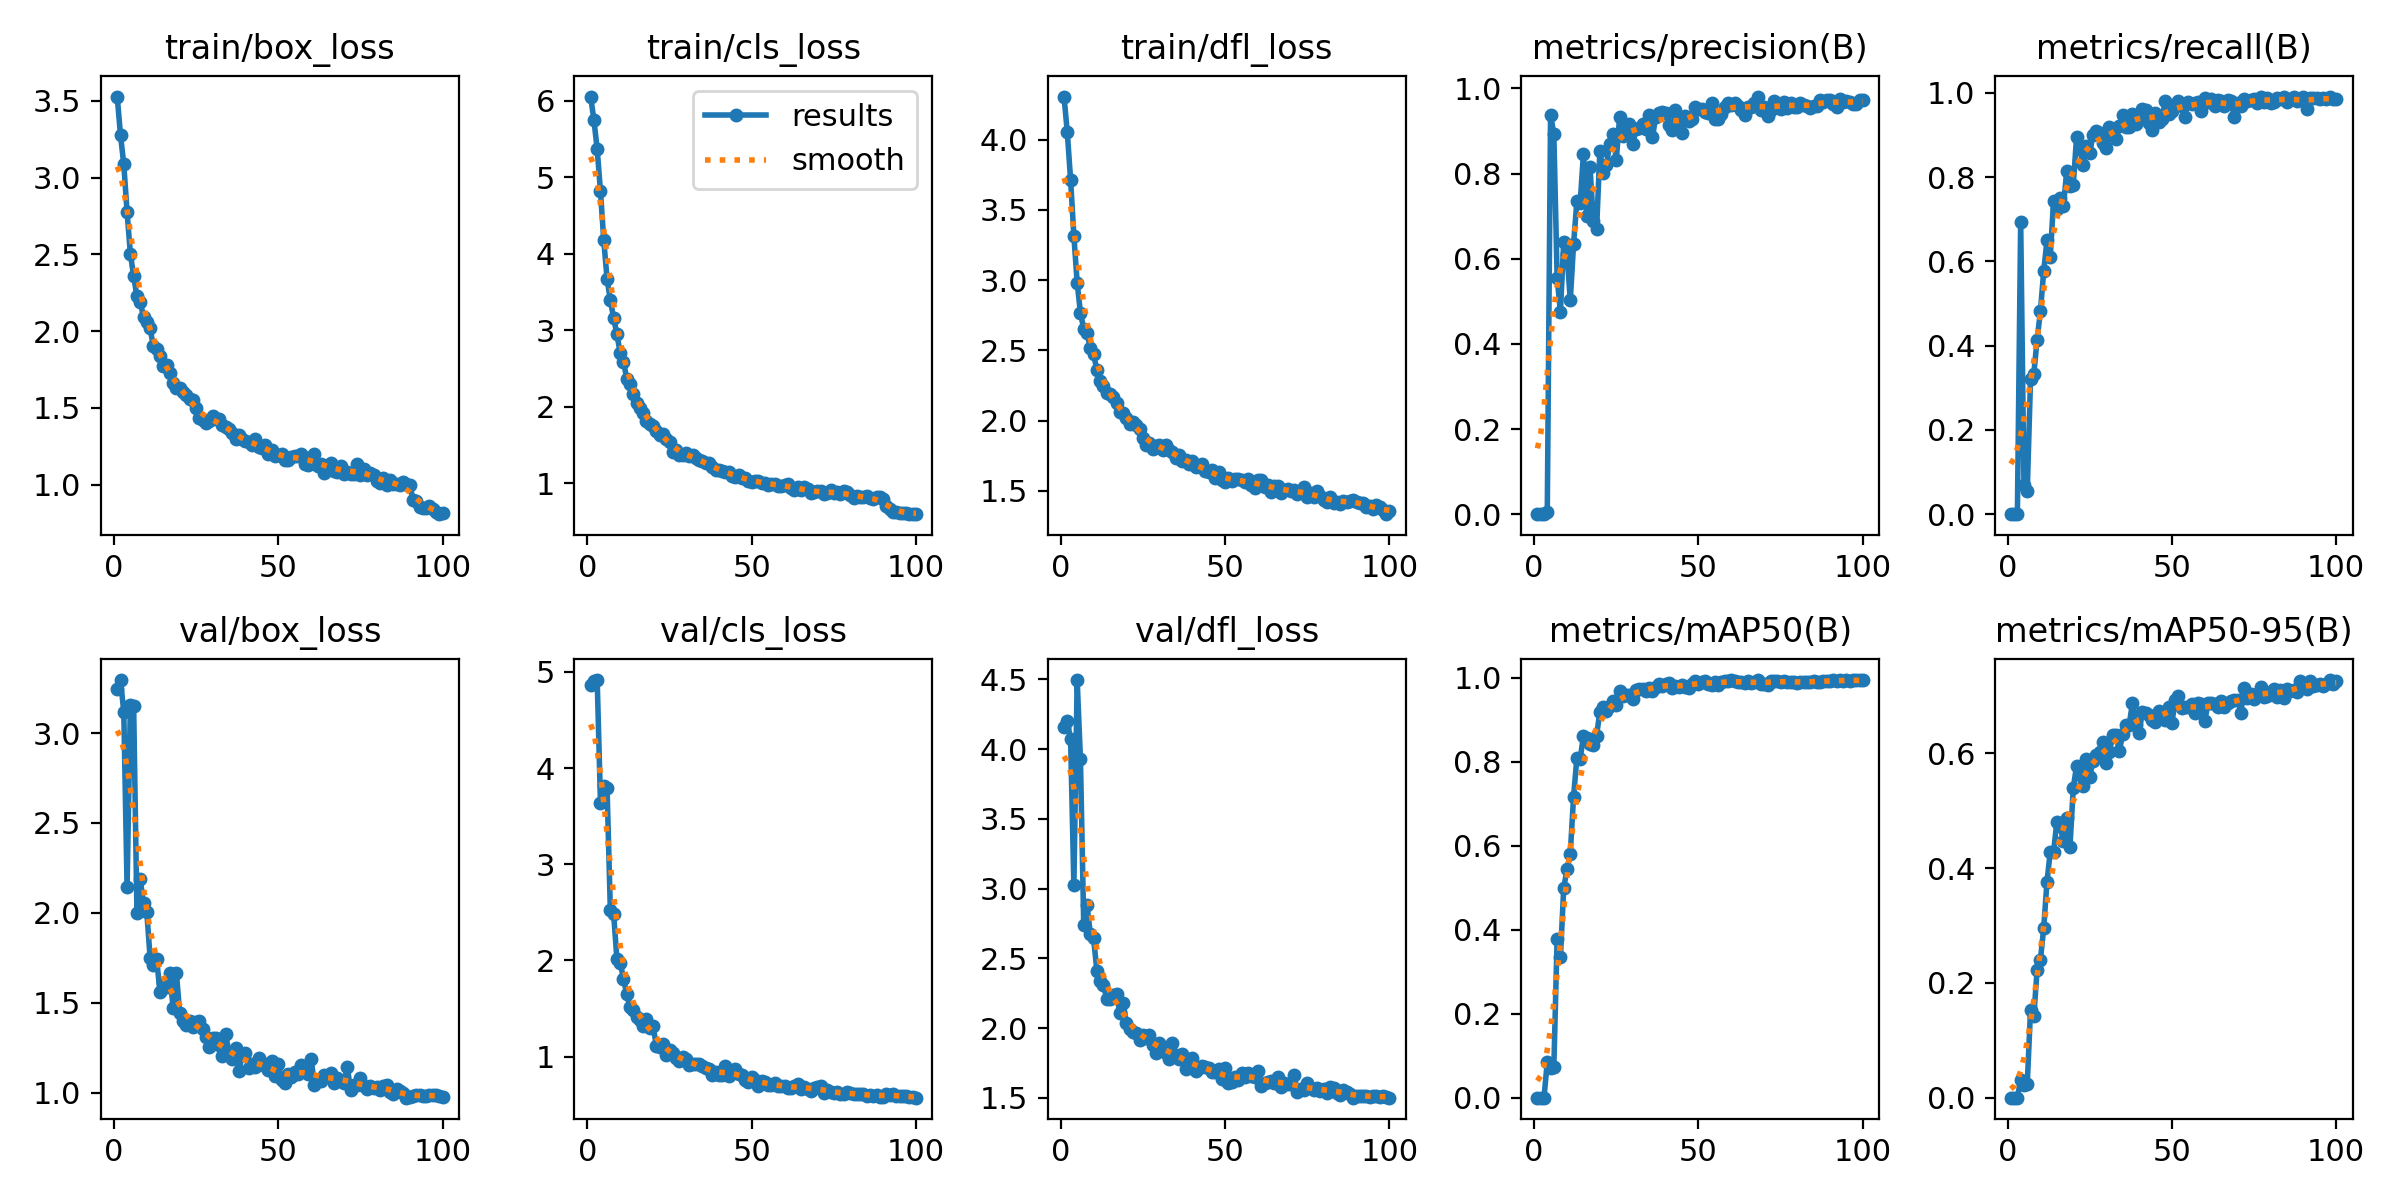

In [11]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [12]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

In [13]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [14]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7181345133668058
mAP 50 0.9702970297029702
mAP 75 0.9223072032477974


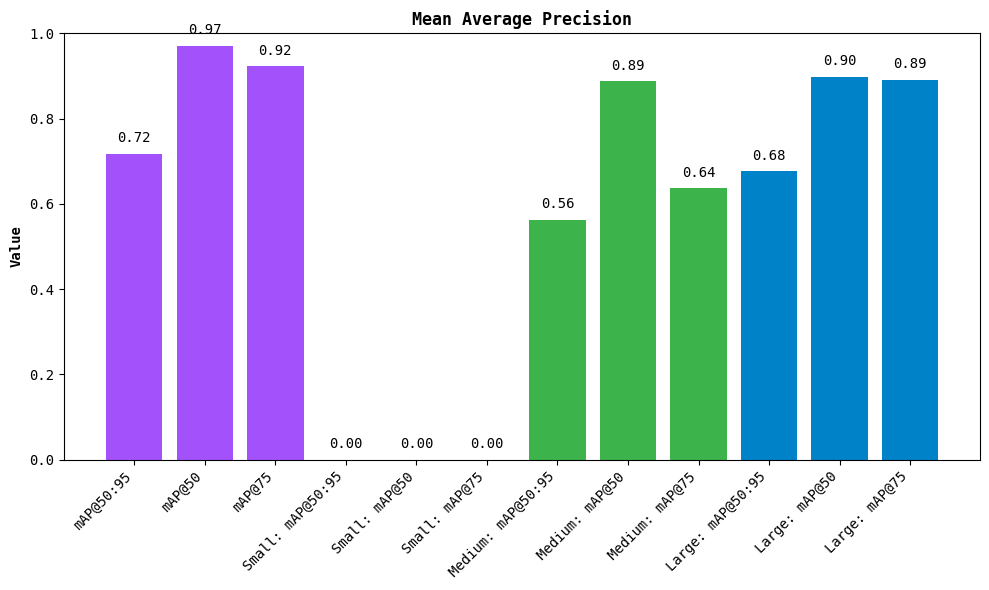

In [15]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [16]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

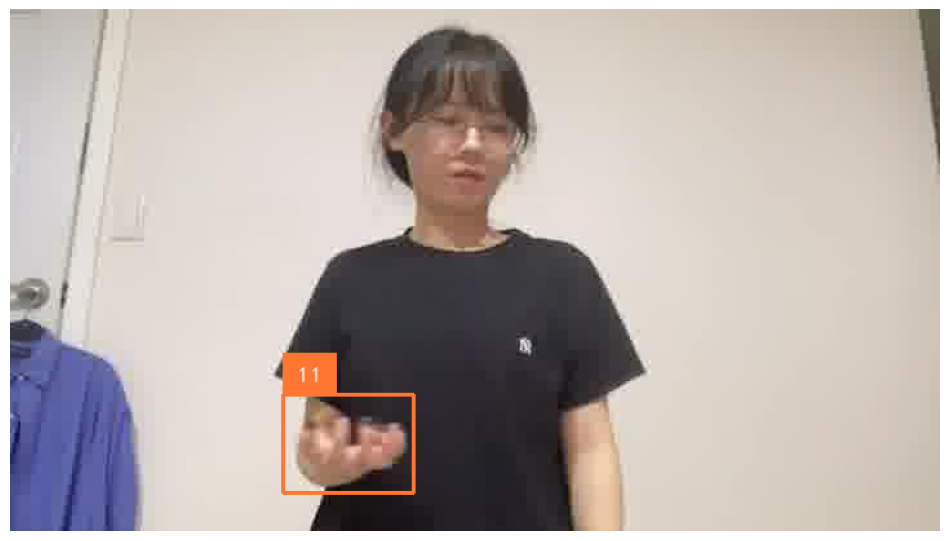

In [19]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)